<a href="https://colab.research.google.com/github/josephassiga/tensorflow-and-keras-tutorial/blob/main/W4/Lab5/W4_Lab_1_intro_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differents kinds of timeseries

A timeseries can be any data obtained via measurements at regular intervals:
*   Daily price of a stock
*   The hourly electricity consumption of a city
*   Weekly sales of a store

The mos common timeseries-related task is *forcasting*: predicting what will happen next in a series.

This are the differents use case that we can accomplish with a time series problems:
* Classification: Assign one or more categorical to a timeseries. Example given timeseries of the activity of visitor, classify whether the visitor is a bot or a human.
* Event detection: Identify the occurence of a specific expected event within a continuous data stream.
* Anomaly detection: detect anything unusual happening within a continuous datastream.



# A temperature forcasting example

We’ll use this temperature-forecasting task to highlight what makes timeseries data fundamentally different from the kinds of datasets you’ve encountered so far.

You’ll see that densely connected networks and convolutional networks aren’t well-equipped to deal with this kind of dataset, while a different kind of machine learning technique—recurrent neural networks (RNNs)—really shines on this type of problem.

We’ll work with a weather timeseries dataset recorded at the weather station at the
Max Planck Institute for Biogeochemistry in Jena, Germany.1
 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)
were recorded every 10 minutes over several years. The original data goes back to
2003, but the subset of the data we’ll download is limited to 2009–2016.
 Let’s start by downloading and uncompressing the data:

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-01 00:16:22--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.215.48, 52.217.170.152, 52.216.37.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.215.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  23.3MB/s    in 0.6s    

2024-04-01 00:16:23 (23.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Now inspecting the data of the Jena weather dataset

In [31]:
import os

filename = os.path.join("jena_climate_2009_2016.csv")

with open(filename) as f:
  data = f.read()

# Retrieve all the content of the file.
lines = data.split("\n")
# Get the header of the file.
header = lines[0].split(",")
# Get other line execpt the header line.
lines = lines[1:]
print(f"Header : {header}")
print(f"Size of the file : {len(lines)}")
print(lines[0].split(",")[:])

Header : ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Size of the file : 420451
['01.01.2009 00:10:00', '996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']


# Parsing the data

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


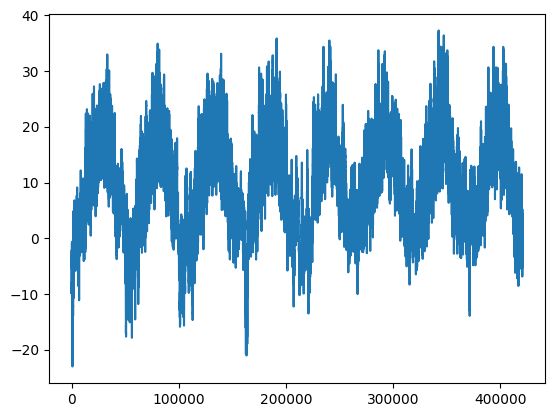

In [33]:
import numpy as np
from matplotlib import pyplot as plt

temperature = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  # For each line, i will only take data exacpt the Date Time
  values = [float(x) for x in line.split(",")[1:]]
  # We store column 1 in the temperature array
  temperature[i] = values[1]
  # We store all columns(including the temperature) in the raw_data
  raw_data[i,:] = values[:]

print(raw_data[0])
plt.plot(range(len(temperature)), temperature)

Computing the number of samples we’ll use for each data split

In [34]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# Preparing the data
The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

 First, let’s preprocess the data to a format a neural network can ingest. This is
easy: the data is already numerical, so you don’t need to do any vectorization. But
each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per
mole, is around 3). We’ll normalize each timeseries independently so that they all
take small values on a similar scale. We’re going to use the first 210,225 timesteps as
training data, so we’ll compute the mean and standard deviation only on this fraction of the data


In [35]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Instantiating datasets for training, validation and testing

In [39]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=0,
 end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Training and evaluating a densely connected model

In [40]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)



callbacks = [
 keras.callbacks.ModelCheckpoint("jena_dense.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 63ms/step - loss: 12.2966 - mae: 2.7169 - val_loss: 10.2409 - val_mae: 2.5267
Epoch 2/10
819/819 [==============================] - 52s 64ms/step - loss: 9.1040 - mae: 2.3731 - val_loss: 10.7089 - val_mae: 2.5936
Epoch 3/10
819/819 [==============================] - 53s 64ms/step - loss: 8.3768 - mae: 2.2792 - val_loss: 10.5093 - val_mae: 2.5625
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 7.8484 - mae: 2.2069 - val_loss: 11.2036 - val_mae: 2.6588
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 7.4938 - mae: 2.1578 - val_loss: 14.8082 - val_mae: 3.0719
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 7.2411 - mae: 2.1228 - val_loss: 11.5956 - val_mae: 2.7119
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 7.0654 - mae: 2.0982 - val_loss: 13.8922 - val_mae: 2.9763
Epoch 8/10
819/819 [==============================] - 

Plotting results

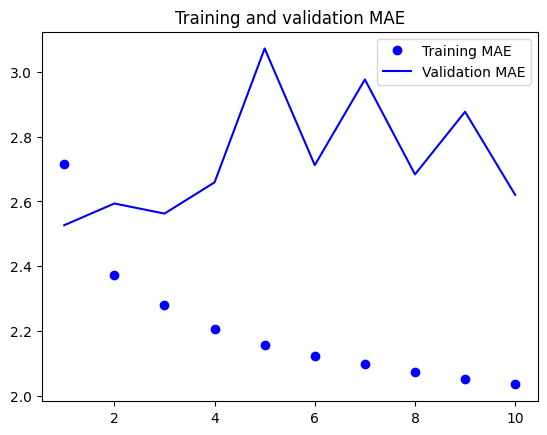

In [41]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()